# TF-IDF -> PCA
# Sentence Transformer -> SVD
# Tuning: Setup -> Feature Extraction -> Hyperparameter Tuning
# Prediction: Setup -> Data Preprocessing (don't save new data) -> Deployment

# Setup

In [1]:
!pip install tqdm numpy gensim nltk pandas scipy==1.11.4
!pip install langdetect
# !pip install pickle
# !pip install pyvi
# !pip install tensorflow transformers
!pip install simpletransformers sentence_transformers fuzzy-c-means bertopic
# !pip install keras-tuner --upgrade
!pip install plotly orca

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=c16c32c5bc70a3dbe160b12b8c798d0034eecffeb9a7b064c866e7e0cc01dd8c
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106


In [2]:
# import tensorflow as tf
# from tensorflow.python.client import device_lib
# from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel
# import torch
import re, os, string
import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
# from simpletransformers.classification import ClassificationModel
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from fcmeans import FCM
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly
import orca
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from collections import Counter
import nltk
nltk.download('all')
from nltk import WordNetLemmatizer, ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from langdetect import detect
from sentence_transformers import SentenceTransformer
# from gradpyent.gradient import Gradients
from bertopic import BERTopic

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

In [3]:
from google.colab import drive, sheets
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
path_root = '/content/drive/MyDrive/Thailand Internship'

path_data_raw = '/content/drive/MyDrive/Thailand Internship/Data/Cyberbullying Youtube.csv'
path_word_raw = '/content/drive/MyDrive/Thailand Internship/Data/Cyberbullying Youtube Words.csv'

path_data_train = '/content/drive/MyDrive/Thailand Internship/Data/Cyberbullying Youtube Train.csv'
path_data_test = '/content/drive/MyDrive/Thailand Internship/Data/Cyberbullying Youtube Test.csv'

path_kmeans_model = '/content/drive/MyDrive/Thailand Internship/Model/kmeans_model.pkl'
path_fcm_model = '/content/drive/MyDrive/Thailand Internship/Model/spectral_model.pkl'

path_bert_hdbscan_model = '/content/drive/MyDrive/Thailand Internship/Model/bert_hdbscan_model.pkl'
path_bert_kmeans_model = '/content/drive/MyDrive/Thailand Internship/Model/bert_kmeans_model.pkl'

path_kmeans_clustered = '/content/drive/MyDrive/Thailand Internship/Output/K-means Clustered.csv'
path_fcm_clustered = '/content/drive/MyDrive/Thailand Internship/Output/Fuzzy C-means Clustered.csv'

path_bert_hdbscan_clustered = '/content/drive/MyDrive/Thailand Internship/Output/Bert Topic - HDBSCAN Clustered.csv'
path_bert_kmeans_clustered = '/content/drive/MyDrive/Thailand Internship/Output/Bert Topic - K-means Clustered.csv'

path_bert_hdbscan_topics = '/content/drive/MyDrive/Thailand Internship/Output/Bert Topic - HDBSCAN Dictionary.csv'
path_bert_kmeans_topics = '/content/drive/MyDrive/Thailand Internship/Output/Bert Topic - K-means Dictionary.csv'

path_visualization = '/content/drive/MyDrive/Thailand Internship/Visualization'

In [5]:
label_keyword_dict = {
    "gender": [
        "sexist", "whore", "female", "male", "woman", "man", "girl", "boy", "feminism",
        "misogyny", "misandry", "patriarchy", "matriarchy", "lesbian", "gay", "transgender",
        "lgbt", "homophobia", "genderqueer", "non-binary", "queer", "transphobia"
    ],
    "religion": [
        "god", "christian", "muslim", "jewish", "hindu", "buddhist", "islam", "catholic",
        "protestant", "atheist", "agnostic", "faith", "church", "mosque", "temple", "synagogue",
        "religious", "blasphemy", "heretic", "jihad", "bible", "quran", "torah", "holy"
    ],
    # "age": [
    #     "age", "old", "young", "teenager", "elderly", "youth", "middle-aged", "child", "baby",
    #     "senior", "adult", "minor", "millennial", "gen z", "boomer", "retirement", "infant",
    #     "geriatric", "puberty", "ageism", "ageist", "youthful"
    # ],
    "ethnicity": [
        "race", "ethnicity", "black", "white", "asian", "hispanic", "latino", "caucasian",
        "african", "american", "indian", "arab", "native", "mexican", "racist", "racism",
        "xenophobia", "immigrant", "nationality", "discrimination", "multicultural", "biracial",
        "slur", "ethnic", "minority", "colonialism", "imperialism"
    ],
    "other_cyberbullying": [
        "bully", "cyberbully", "harass", "abuse", "attack", "insult", "slander", "gaslight",
        "ridicule", "humiliate", "demean", "idiot", "shame", "blackmail", "extort", "manipulate",
        "verbal", "abusive", "vulgar", "obscene", "fuck", "fucking", "stupid", "asshole", "offend",
    ],
}

# Data Preprocesssing

In [6]:
data_raw = pd.read_csv(path_data_raw)
data_raw.fillna(method ='ffill', inplace = True)

list_comment_raw = []
list_label_raw = []

list_bully_type = ["not_cyberbullying", "gender", "religion", "ethnicity", "other_cyberbullying"] # age

for btype in list_bully_type:
  list_comment_raw.extend(data_raw[data_raw['Type'] == btype]['Comment'].values[:1000]) # Add 1000 values ​​to the list one by one, not an array containing 1000 values
  list_label_raw.extend(np.full(1000, btype))

print("Loaded",len(list_comment_raw),"comments from",path_data_raw)

Loaded 5000 comments from /content/drive/MyDrive/Thailand Internship/Data/Cyberbullying Youtube.csv


In [7]:
def clean_text(text):
    # text = "".join(map(str, text))
    text = re.sub(r"http\S+", "", text) # remove link (r: raw string)
    text = re.sub(r"@\S+", "", text) # remove username
    text = re.sub(r"#\S+", "", text) # remove hashtag
    text = re.sub('<.*?>', '', text) # remove HTML tags and strip
    text = re.sub('(\s)+', r'\1', text) # consecutive spaces -> single space
    return text

def sentence_segment(text): # segment a multi-sentence comment
    sents = re.split("([.?!])?[\n]+|[.?!]", text)
    return sents

def normalize_text(text):
  if text == None:
    return

  for i in string.punctuation:
    text = text.replace(i, ' ')

  return re.sub('[^\w\s]', '', text).strip().lower() # remove special characters

In [8]:
def word_segment(sent):
    words = word_tokenize(sent)
    return words

def remove_stopword(words):
    list_stop_words = set(stopwords.words('english'))
    filtered_words = []

    for w in words:
      if w not in list_stop_words:
          filtered_words.append(w)

    return filtered_words

def lemmatize(words):
  lemmatizer = WordNetLemmatizer()
  lemmatized_words = [lemmatizer.lemmatize(w) for w in words]

  return lemmatized_words

In [9]:
def check_valid_sentence(sentence, testing=False):
  if not (sentence == None or sentence.strip().isdigit() or len(sentence.strip()) < 10):
    if detect(sentence) == 'en' or testing == True:
      return True
  return False

def check_valid_word(word):
  list_stop_words = set(stopwords.words('english'))
  return word not in list_stop_words

In [10]:
def relabel_comment(comment):
    for label, keywords in label_keyword_dict.items():
      if any(keyword in comment.lower() for keyword in keywords):
          return label
    return "not_cyberbullying"

In [11]:
def preprocess_data(list_comment_raw, list_label_raw=None, testing=False):
  list_comment_cleaned = []
  list_label_cleaned = []
  list_word_raw = []

  for i, comment in tqdm(enumerate(list_comment_raw)):
    sentences = sentence_segment(clean_text(comment))

    for sentence in sentences:
      normalized_sentence = normalize_text(sentence)

      if check_valid_sentence(normalized_sentence, testing):
        words = word_segment(normalized_sentence)

        filtered_words = remove_stopword(words)
        lemmatized_words = lemmatize(filtered_words)

        for word in lemmatized_words:
          if check_valid_word(word):
            list_word_raw = np.append(list_word_raw, word)

        cleaned_sentence = ' '.join(lemmatized_words)

        if cleaned_sentence not in list_comment_cleaned and check_valid_sentence(cleaned_sentence, testing):
          list_comment_cleaned = np.append(list_comment_cleaned, cleaned_sentence)
          if list_label_raw != None:
            # list_label_cleaned = np.append(list_label_cleaned, list_label_raw[i])
            list_label_cleaned = np.append(list_label_cleaned, relabel_comment(cleaned_sentence))
    # if(i%100==0):
    #     print("Preprocessed comments:", i, "/", len(list_comment_raw))

  # list_word_cleaned = list(set(list_word_raw))
  # print("Preprocessed successfully!")

  if list_label_raw != None:
    return list_comment_cleaned, list_label_cleaned, list_word_raw

  return list_comment_cleaned, list_word_raw

In [12]:
list_comment_cleaned, list_label_cleaned, list_word_raw = preprocess_data(list_comment_raw, list_label_raw)

list_comment_train, list_comment_test, list_label_train, list_label_test = train_test_split(list_comment_cleaned, list_label_cleaned, test_size=0.1, shuffle=True)

5000it [06:09, 13.54it/s]


In [13]:
dict_data_train = {'Comment': list_comment_train, 'Type': list_label_train}
dict_data_test = {'Comment': list_comment_test, 'Type': list_label_test}

df_data_train = pd.DataFrame(dict_data_train)
df_data_test = pd.DataFrame(dict_data_test)

df_data_train.to_csv(path_data_train, index=False)
df_data_test.to_csv(path_data_test, index=False)

In [14]:
list_word_raw[:10]

array(['word', 'food', 'crapilicious', 'white', 'classy', 'whore', 'p',
       'thanks', 'head', 'concerned'], dtype='<U32')

In [15]:
dict_word_raw = {'Word': list_word_raw}
df_word_raw = pd.DataFrame(dict_word_raw)

df_word_raw.to_csv(path_word_raw, index=False)

# Feature Extraction (Embedding)

In [ ]:
df_data_train = pd.read_csv(path_data_train)
list_comment_train = df_data_train['Comment'].values

In [ ]:
# # Vectorize words
# vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, min_df=5)
# E.g: max_df=50(times), min_df=0.1(%) - Ignore terms that appear in > 80% of document and < 5 times
# X = vectorizer.fit_transform(list_comment_train).toarray()

In [ ]:
# # Embed sentences
sent_transformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')
X = sent_transformer.encode(list_comment_train).astype(np.float64)
X

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

array([[-9.35804471e-02, -9.07885209e-02, -3.46554816e-01, ...,
        -3.53453934e-01,  4.47478771e-01,  1.53543457e-01],
       [ 1.67771772e-01, -8.57476518e-02, -2.33976200e-01, ...,
        -2.33664870e-01,  4.46974754e-01, -8.10579300e-01],
       [-5.93956053e-01,  2.89831936e-01,  1.10289253e-01, ...,
         5.64225316e-02,  5.28779812e-02, -1.07091072e-03],
       ...,
       [-2.56879274e-02,  2.81915605e-01,  1.52289867e-03, ...,
         5.65276802e-01,  1.41511023e+00,  7.50163198e-02],
       [-5.94932556e-01, -5.85693754e-02,  1.57616511e-01, ...,
        -1.94123194e-01, -3.53915215e-01,  4.01662946e-01],
       [-6.89977407e-01,  7.91069686e-01,  6.45311624e-02, ...,
        -5.81205726e-01,  1.11860283e-01,  6.57215357e-01]])

In [ ]:
# # Load pre-trained BERT model and tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')

# def get_cls_sentence(sentence):
#     # Tokenize input sentence and convert to tensor
#     input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])

#     # Pass input through BERT model and extract embeddings for [CLS] token
#     with torch.no_grad(): # don't update the gradient because this is not a training step
#         outputs = model(input_ids)
#         cls_embedding = outputs[0][:, 0, :]

#     return cls_embedding.flatten()

# X = [get_cls_sentence(sentence) for sentence in list_comment_train]

# Dimensionality Reduction

In [ ]:
# pca = PCA(n_components=3)
# X_reduced = pca.fit_transform(X)

In [ ]:
svd = TruncatedSVD(n_components=3)
X_reduced = svd.fit_transform(X)

In [ ]:
# lda = LDA(n_components=3)
# X_reduced = lda.fit_transform(X, y)

# Data Visualization

In [ ]:
df_data_train = pd.read_csv(path_data_train)
list_comment_train = df_data_train['Comment'].values

list_sentence = [comment.split(' ') for comment in list_comment_train]

df_word_raw = pd.read_csv(path_word_raw)
list_word_raw = df_word_raw['Word'].values

# window (int, optional) – Maximum distance between the current and predicted word within a sentence.
# min_count (int, optional) – Ignores all words with total frequency lower than this.
# sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.
# workers - number of threads to train the model
# cbow_mean ({0, 1}, optional) – If 0, use the sum of the context word vectors. If 1, use the mean, only applies when cbow is used.
# negative (int, optional) – Number of negative sampling will be used (noise words) (usually between 5-20).
word2vec_model = Word2Vec(list_sentence, vector_size=100, window=5, min_count=2, sample=0.001, workers=4, negative=20, sg=0, cbow_mean=0, epochs=50)

tsne_model = TSNE(perplexity=5, n_components=3, init='pca', n_iter=2500, random_state=23) # perplexity = number of nearest neighbors

In [ ]:
def hex_to_RGB(hex_str):
    """#FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """Given two hex colors, returns a color gradient with n colors."""
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

In [ ]:
def visualize_word(df):
  specs = [[{'type': 'scatter3d'}, {'type': 'domain'}]] # specifications of subplot type, row/column spanning, and spacing.
  fig = sp.make_subplots(rows=1, cols=2, specs=specs, horizontal_spacing = 0.05,
                         subplot_titles=('Similarity, length and frequency of unigrams', 'Percentage of unigrams'))

  fig.add_trace(
    go.Scatter3d(
                x=df['x'],
                y=df['y'],
                z=df['z'],
                text=df['word'],
                hoverinfo='text',
                mode='text+markers',
                marker=dict(
                  size=df['frequency']/10,
                  color=df['length'],
                  colorscale='Cividis',
                  opacity=0.8,
                  colorbar=dict(
                      title='Length',
                      orientation='h',
                      y=-0.5,
                  )
                ),
    ),
    row=1, col=1,
  )

  fig.add_trace(
    go.Pie(values=df['frequency'],
           labels=df['word'],
           marker=dict(
              colors=get_color_gradient("#112D60", "#DD83E0", len(df['word']))
              ),
    ),
    row=1, col=2,
  )

  fig.update_layout(template='plotly_white')

  # fig.write_image(file=f"{path_visualization}/Word Visualization.png", format='.png', engine='kaleido')

  fig.show()

In [ ]:
# @title Word Visualization { run: "auto" }

n_words = 15 # @param {type:"slider", min:10, max:50, step:1}

word_freq = Counter(list_word_raw)
common_words = word_freq.most_common(n_words)
words, frequencies = zip(*common_words) # unzip
lengths = [len(w) for w in words]

tokens = np.array([word2vec_model.wv[word] for word in words])
embed_words = tsne_model.fit_transform(tokens)

df_word_cleaned = pd.DataFrame({
                    'word': words,
                    'frequency': frequencies,
                    'length': lengths,
                    'x': embed_words[:, 0],
                    'y': embed_words[:, 1],
                    'z': embed_words[:, 2],
                    })

visualize_word(df_word_cleaned)

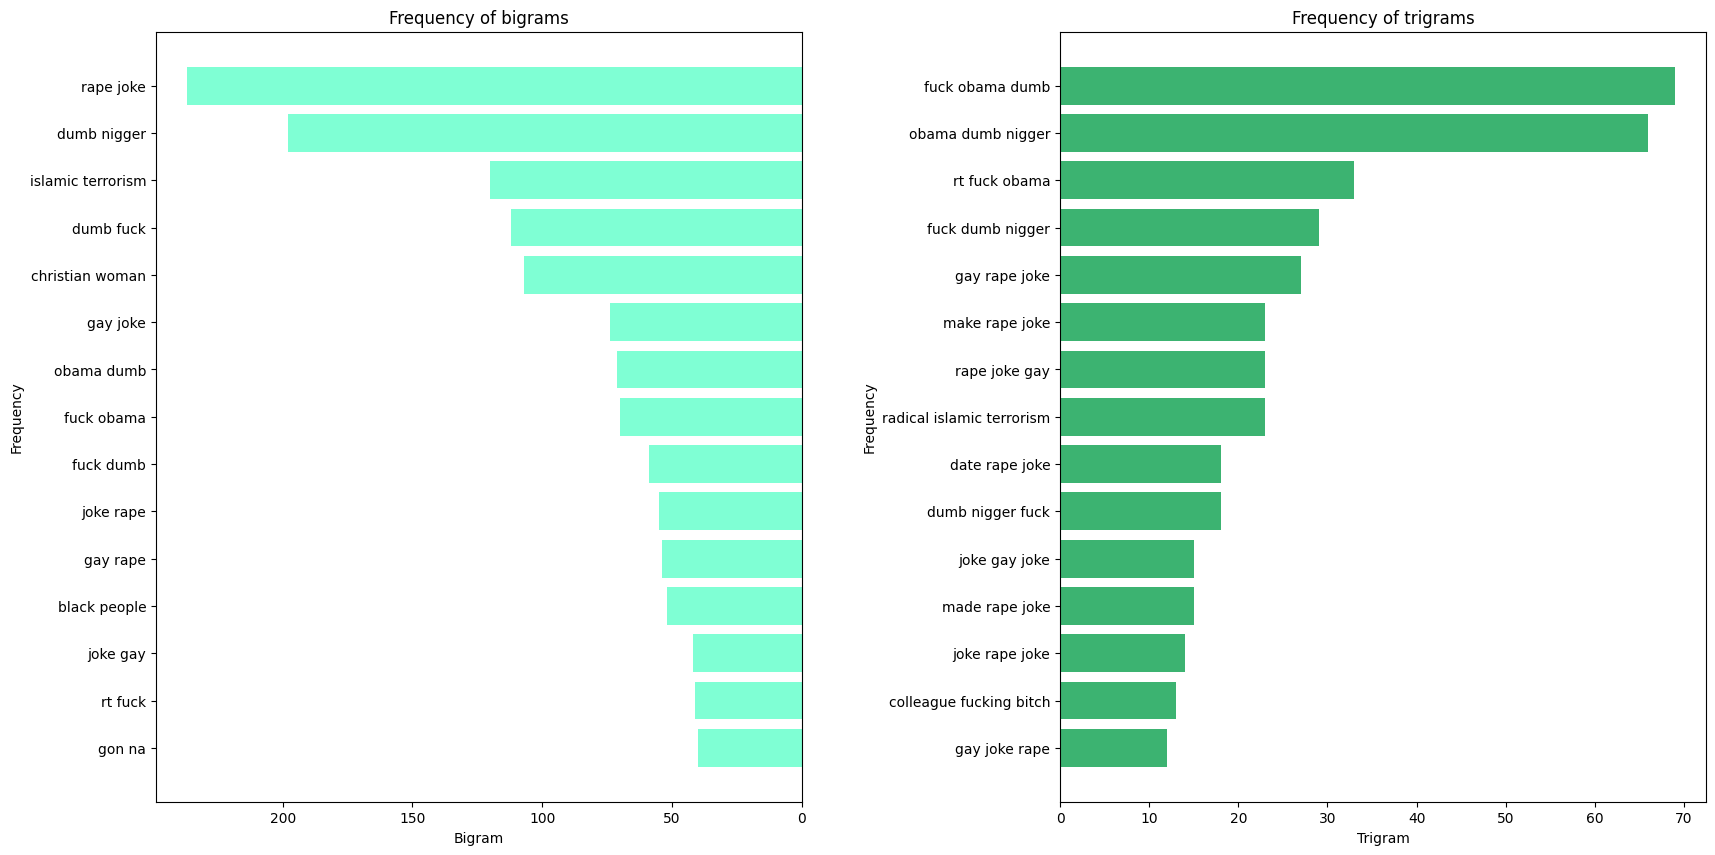

In [ ]:
# @title N-grams Visualization { run: "auto" }
n_words = 15 # @param {type:"slider", min:10, max:50, step:1}

bigram_list = list(ngrams(list_word_raw, 2)) # [('united', 'state'), ('state', 'cooked'),...]
bigram_list = [' '.join(bi) for bi in bigram_list]

bigram_counter = Counter(bigram_list)
bigrams, bi_freq = zip(*bigram_counter.most_common(n_words)) # unzip

trigram_list = list(ngrams(list_word_raw, 3))
trigram_list = [' '.join(tri) for tri in trigram_list]

trigram_counter = Counter(trigram_list)
trigrams, tri_freq = zip(*trigram_counter.most_common(n_words)) # unzip

# Bước 4: Tạo biểu đồ thanh
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0.4,
                    hspace=0.4)

ax1 = fig.add_subplot(121)
ax1.barh(bigrams, bi_freq, color='aquamarine')
ax1.set_title('Frequency of bigrams')
ax1.set_xlabel('Bigram')
ax1.set_ylabel('Frequency')
ax1.invert_yaxis()  # Put the most common words at the top
ax1.invert_xaxis()

ax2 = fig.add_subplot(122)
ax2.barh(trigrams, tri_freq, color='mediumseagreen')
ax2.set_title('Frequency of trigrams')
ax2.set_xlabel('Trigram')
ax2.set_ylabel('Frequency')
ax2.invert_yaxis()  # Put the most common words at the top

plt.show()

# K-means

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans_clusters = kmeans.fit_predict(X)

In [ ]:
df_kmeans_clustered = pd.DataFrame(zip(list_comment_train, kmeans_clusters), columns=['Comment', 'Cluster'])

for i in range(5):
  print(df_kmeans_clustered[df_kmeans_clustered['Cluster'] == i].head(10))

                                               Comment  Cluster
1                                         classy whore        0
19                                     isso é bullying        0
31    look dc public school bullying lgbt student gone        0
43      noticed save witty reply sexist little panache        0
44                   yeap breeding violence thing well        0
51   rt ceo sony europe vehemently unequivocally co...        0
68                  best martial art stopping bullying        0
87              evidence intentionally targeting child        0
93   minnesota gay teen bullied adult peer say acti...        0
126                                 sociedade bullying        0
                                              Comment  Cluster
0                              word food crapilicious        1
2   p thanks head concerned another angry dude twi...        1
7                                      bully flush kd        1
12                love people call james pot

In [ ]:
# Type: "other_cyberbullying", "religion", "not_cyberbullying", "ethnicity", "gender",

# Mapping labels from int -> string to compare
kmeans_mapping = []

for i in range(5):
  kmeans_mapping.append(input(f"Name the cluster {i}: "))

df_kmeans_clustered['Cluster'] = df_kmeans_clustered['Cluster'].map(lambda x: kmeans_mapping[int(x)])

Name the cluster 0: gender
Name the cluster 1: other_cyberbullying
Name the cluster 2: ethnicity
Name the cluster 3: not_cyberbullying
Name the cluster 4: religion


In [ ]:
# # Fuzzy C-Means is a fuzzy clustering method that groups clusters that do not have clear separation or contain too few data points into one
# fcm = FCM(n_clusters=5, m = 5) # m: fuzziness coefficient, higher m make clusters more clearly separated
# fcm.fit(X)
# fcm_clusters = fcm.predict(X)
# # fcm_clusters = 1 - fcm_clusters # swap labels 0 and 1: 1 - labels 1 = 0, 1 - labels 0 = 1

In [ ]:
# df_fcm_clustered = pd.DataFrame(zip(list_comment_train, fcm_clusters), columns=['Comment', 'Cluster'])

# for i in range(5):
#   print(df_fcm_clustered[df_fcm_clustered['Cluster'] == i].head(10))

In [ ]:
# # "not_cyberbullying", "religion", "ethnicity", "gender", "other_cyberbullying",

# # Mapping labels from int -> string to compare
# fcm_mapping = []

# for i in range(5):
#   fcm_mapping.append(input(f"Name the cluster {i}: "))

# df_fcm_clustered['Cluster'] = df_fcm_clustered['Cluster'].map(lambda x: fcm_mapping[int(x)])
# df_fcm_clustered

In [ ]:
pickle.dump(kmeans, open(path_kmeans_model, 'wb')) # write binary
# pickle.dump(fcm, open(path_fcm_model, 'wb')) # write binary

In [ ]:
df_kmeans_clustered.to_csv(path_kmeans_clustered, index=False)
# df_fcm_clustered.to_csv(path_fcm_clustered, index=False)

# Bert Topic

In [ ]:
df_data_train = pd.read_csv(path_data_train)
list_comment_train = df_data_train['Comment'].values

## HDBSCAN

In [49]:
# min_topic_size=50: keep only topics with sufficient number of documents
# nr_topics=7: merge topics by fixed number
topic_model = BERTopic(min_topic_size=50)
topics, probs = topic_model.fit_transform(list_comment_train)

reduced_topics = topic_model.reduce_outliers(list_comment_train, topics, strategy="embeddings") # c-tf-idf, embeddings, distributions
topic_model.update_topics(list_comment_train, topics=reduced_topics)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# Topic -1: Documents are not assigned to a specific topic.
# Count: number of do/cuments belonging to each topic.
# Name: Name of the topic
# Representation: Keywords that represent that topic.
# Representative_Docs: Documents that represent the topic.
df_raw_topic=topic_model.get_topic_info()
sheet = sheets.InteractiveSheet(df=df_raw_topic, title='Interactive Raw Topic Sheet')

https://docs.google.com/spreadsheets/d/1mNhaAvsnEKWVxmNb9TphABPAFqSVnmdTMNCpoSihh0c#gid=0


In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
# topic_model.visualize_topics(custom_labels=True)
# topic_model.visualize_document_datamap(list_comment_train)
topic_model.visualize_documents(list_comment_train)

In [ ]:
topics_to_merge = [[0, 5, 10], # religion
                  [1, 12], # ethnicity
                  [2, 6, 8], # gender
                  [4, 7, 9], # other
                  [3, 11, 13, 14],] # not
topic_model.merge_topics(list_comment_train, topics_to_merge)

df_merged_topic=topic_model.get_topic_info()
df_merged_topic

,Topic,Count,Name,Representation,Representative_Docs
0,0,1491,0_amp_one_first_think,"[amp, one, first, think, know, time, ur, thing...",[flopped first time pls like think im nice rt ...
1,1,1481,1_muslim_christian_terrorist_islamic,"[muslim, christian, terrorist, islamic, terror...",[atia need correct speech idiot belongs muslim...
2,2,974,2_joke_rape_gay_woman,"[joke, rape, gay, woman, female, call, bitch, ...",[clearly product time could make rape joke lik...
3,3,873,3_rt_bully_idiot_bullying,"[rt, bully, idiot, bullying, fuck, like, dumb,...",[real rt mom would let fuck rt seahawks bunch ...
4,4,850,4_nigger_dumb_fuck_black,"[nigger, dumb, fuck, black, white, as, people,...",[fuck obama dumb as nigger bitch shut yo white...


In [ ]:
topic_model.visualize_barchart(top_n_topics=8, n_words=5)

In [ ]:
topic_model.set_topic_labels({
                             -1: "outlier",
                              0: "not_cyberbullying",
                              1: "religion",
                              2: "gender",
                              3: "other_cyberbullying",
                              4: "ethnicity",
                            })

df_cleaned_topic=topic_model.get_topic_info()
df_cleaned_topic

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,0,1491,0_amp_one_first_think,not_cyberbullying,"[amp, one, first, think, know, time, ur, thing...",[flopped first time pls like think im nice rt ...
1,1,1481,1_muslim_christian_terrorist_islamic,religion,"[muslim, christian, terrorist, islamic, terror...",[atia need correct speech idiot belongs muslim...
2,2,974,2_joke_rape_gay_woman,gender,"[joke, rape, gay, woman, female, call, bitch, ...",[clearly product time could make rape joke lik...
3,3,873,3_rt_bully_idiot_bullying,other_cyberbullying,"[rt, bully, idiot, bullying, fuck, like, dumb,...",[real rt mom would let fuck rt seahawks bunch ...
4,4,850,4_nigger_dumb_fuck_black,ethnicity,"[nigger, dumb, fuck, black, white, as, people,...",[fuck obama dumb as nigger bitch shut yo white...


In [ ]:
topic_model.save(path_bert_hdbscan_model, serialization="pickle")

2024-08-16 08:10:32,597 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
df_cleaned_topic.to_csv(path_bert_hdbscan_topics, index=False)

In [ ]:
document_info = topic_model.get_document_info(list_comment_train)

df_bertopic_clustered = document_info[["Document", "CustomName"]]
df_bertopic_clustered = df_bertopic_clustered.rename(columns={"Document": "Comment", "CustomName": "Cluster"})

df_bertopic_clustered['Cluster'] = df_bertopic_clustered['Cluster'].replace("outlier", method='ffill').replace("outlier", method='bfill')

df_bertopic_clustered

,Comment,Cluster
0,word food crapilicious,not_cyberbullying
1,classy whore,gender
2,p thanks head concerned another angry dude twi...,not_cyberbullying
3,isi account pretending kurdish account,religion
4,yes test god good bad indifferent weird whatev...,religion
...,...,...
5664,phone necessarily stored,gender
5665,name would required,not_cyberbullying
5666,let explain word problematic,gender
5667,everyone kept bullying tonight toe lolling co ...,other_cyberbullying


In [ ]:
df_bertopic_clustered.to_csv(path_bert_hdbscan_clustered, index=False)

## K-Means

In [153]:
sentence_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
dim_model = PCA(n_components=5)
cluster_model = KMeans(n_clusters=5)

topic_model = BERTopic(embedding_model=sentence_model, umap_model=dim_model, hdbscan_model=cluster_model)
topics, probs = topic_model.fit_transform(list_comment_train)

In [154]:
topic_model.visualize_barchart(top_n_topics=8, n_words=5)

In [155]:
topic_model.set_topic_labels({
                              0: "not_cyberbullying",
                              1: "religion",
                              2: "other_cyberbullying",
                              3: "gender",
                              4: "ethnicity",
                            })

df_cleaned_topic=topic_model.get_topic_info()
df_cleaned_topic

,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,0,1831,0_rt_one_first_know,not_cyberbullying,"[rt, one, first, know, time, think, like, ur, ...","[get number right first, first time u, think u..."
1,1,877,1_muslim_islamic_terrorist_terrorism,religion,"[muslim, islamic, terrorist, terrorism, islam,...",[u know islamic terrorism every country say is...
2,2,854,2_fuck_dumb_nigger_as,other_cyberbullying,"[fuck, dumb, nigger, as, bitch, fucking, shit,...","[fuck dumb fuck, fuck dumb bitch, rt fuck obam..."
3,3,849,3_rape_joke_gay_woman,gender,"[rape, joke, gay, woman, female, call, sexist,...",[clearly product time could make rape joke lik...
4,4,691,4_black_white_people_racist,ethnicity,"[black, white, people, racist, racism, called,...",[black guy racist got offended white guy calle...


In [156]:
topic_model.save(path_bert_kmeans_model, serialization="pickle")

2024-08-17 16:42:18,411 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [157]:
df_cleaned_topic.to_csv(path_bert_kmeans_topics, index=False)

In [158]:
document_info = topic_model.get_document_info(list_comment_train)

df_bertopic_clustered = document_info[["Document", "CustomName"]]
df_bertopic_clustered = df_bertopic_clustered.rename(columns={"Document": "Comment", "CustomName": "Cluster"})

df_bertopic_clustered['Cluster'] = df_bertopic_clustered['Cluster'].replace("outlier", method='ffill').replace("outlier", method='bfill')

df_bertopic_clustered

,Comment,Cluster
0,look democrat support cultural site never say ...,religion
1,come long way,not_cyberbullying
2,fuckin idiot lmao attracted islam,religion
3,every day brings u closer able make announcement,not_cyberbullying
4,democrat become radical leftist,ethnicity
...,...,...
5097,clip bull hawk,other_cyberbullying
5098,muslim video say muslim problem even someone r...,religion
5099,egg thing unfortunately part likely open sourced,not_cyberbullying
5100,guess becomes chair,not_cyberbullying


In [159]:
df_bertopic_clustered.to_csv(path_bert_kmeans_clustered, index=False)

# Evaluation

In [ ]:
def visualize_3d(title, X_reduced, clusters, centers):
  plt.figure(figsize=(10, 7))
  plt.title(title)

  ax = plt.axes(projection = "3d")
  p = ax.scatter3D(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=clusters, cmap='rainbow') # 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
  ax.set_xlabel("Principal Component 1")
  ax.set_ylabel("Principal Component 2")
  ax.set_zlabel("Principal Component 3")

  # Adding cluster centers to the plot
  centers_reduced = svd.transform(centers)
  ax.scatter3D(centers_reduced[:, 0], centers_reduced[:, 1], centers_reduced[:, 2], c='#FF6961', s=200, alpha=0.75, marker='*')

  # # Adding labels to the plot
  # for i, txt in enumerate(list_comment_train):
  #     plt.annotate(txt, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=9, alpha=0.75)

  plt.colorbar(p, label='Cluster Label')

  plt.show()

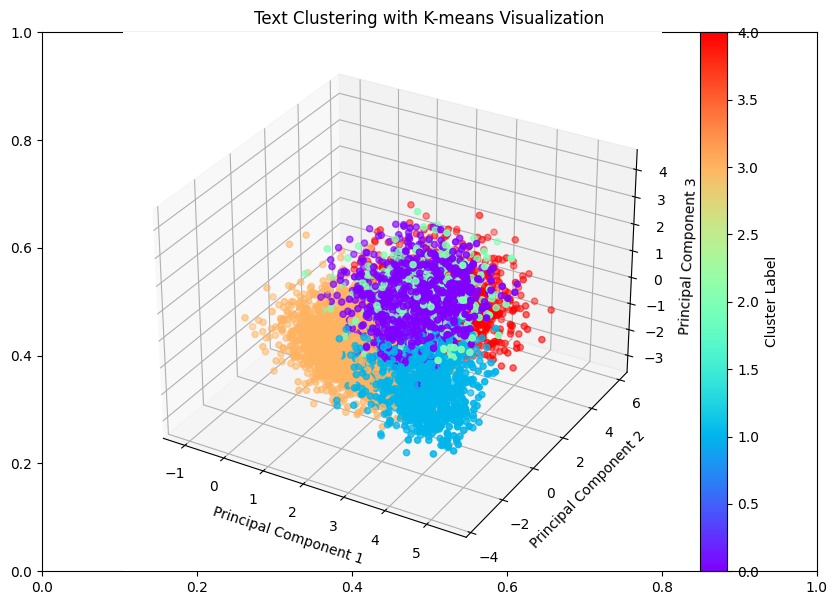

In [ ]:
kmeans_centers = kmeans.cluster_centers_
visualize_3d("Text Clustering with K-means Visualization", X_reduced, kmeans_clusters, kmeans_centers)

In [ ]:
# fcm_centers = fcm.centers
# visualize_3d("Text Clustering with Fuzzy C-means Visualization", X_reduced, fcm_clusters, fcm_centers)

In [ ]:
topic_model.visualize_documents(list_comment_train, custom_labels=True)

In [105]:
df_data_test = pd.read_csv(path_data_test)
list_comment_test = df_data_test['Comment'].values
list_label_test = []

list_comment_test, list_label_test, list_word_test = preprocess_data(list_comment_test, list_label_test)

sent_transformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')
X_test = sent_transformer.encode(list_comment_test).astype(np.float64)

In [160]:
loaded_kmeans = pickle.load(open(path_kmeans_model, "rb")) # read binary
# loaded_fcm = pickle.load(open(path_fcm_model, "rb")) # read binary
loaded_bert_kmeans = BERTopic.load(path_bert_kmeans_model)

idx2name_kmeans = ["gender", "other_cyberbullying", "ethnicity", "not_cyberbullying", "religion"]
idx2name_bert = ["not_cyberbullying", "religion", "other_cyberbullying", "gender", "ethnicity"]

In [161]:
kmeans_test = loaded_kmeans.predict(X_test)
kmeans_cluster = [idx2name_cluster[idx] for idx in kmeans_test]

# fcm_test = loaded_fcm.predict(X_test)
# fcm_cluster = [idx2name_cluster[idx] for idx in fcm_test]

bert_test, probs = loaded_bert_kmeans.transform(list_comment_test)
bert_cluster = [idx2name_bert[idx] for idx in bert_test]

In [162]:
acc_kmeans = accuracy_score(y_true=list_label_test, y_pred=kmeans_cluster)
f1_kmeans = f1_score(y_true=list_label_test, y_pred=kmeans_cluster, average='weighted')

# acc_fcm = accuracy_score(y_true=list_label_test, y_pred=fcm_cluster)
# f1_fcm = f1_score(y_true=list_label_test, y_pred=fcm_cluster, average='weighted')

acc_bertopic = accuracy_score(y_true=list_label_test, y_pred=bert_cluster)
f1_bertopic = f1_score(y_true=list_label_test, y_pred=bert_cluster, average='weighted')

print("K-means Accuracy:", acc_kmeans)
print("K-means F1 Score:", f1_kmeans)

# print("Fuzzy C-means Accuracy:", acc_fcm)
# print("Fuzzy C-means F1 Score:", f1_fcm)

print("Bert Topic Accuracy:", acc_bertopic)
print("Bert Topic F1 Score:", f1_bertopic)

K-means Accuracy: 0.7495256166982922
K-means F1 Score: 0.7511164837209787
Bert Topic Accuracy: 0.7039848197343453
Bert Topic F1 Score: 0.7142883465696994


# Hyperparameter Tuning

In [ ]:
# kmeans_sse = []
kmeans_scores = []
fcm_scores = []
bert_scores = []

n_clusters = np.arange(2, 21, 2, dtype=int).tolist()

In [ ]:
for i in n_clusters:
  kmeans = KMeans(n_clusters=i, n_init='auto')
  kmeans_clusters = kmeans.fit_predict(X)

  # Lower inertia indicates tighter and well-separated clusters
  # kmeans_sse.append(kmeans.inertia_)
  kmeans_scores.append(silhouette_score(X, kmeans_clusters))

# print('SSE of K-means =' , kmeans_sse)
print('Silhouette Score of K-means =', kmeans_scores)

Silhouette Score of K-means = [0.04508744091416284, 0.0291219241834648, 0.030115244851205748, 0.02171173945336105, 0.017882260172469567, 0.01648204681898683, 0.025417341804747525, 0.02283573407844549, 0.028293959167732807, 0.02173619019244251]


In [ ]:
for i in n_clusters:
  fcm = FCM(n_clusters = i, m = 2.5)
  fcm.fit(X)
  fcm_clusters = fcm.predict(X) # swap labels 0 and 1: 1 - labels 1 = 0, 1 - labels 0 = 1

  fcm_scores.append(silhouette_score(X, fcm_clusters))

print('Silhouette Score of Fuzzy C-means =', fcm_scores)

Silhouette Score of Fuzzy C-means = [0.04232075980282548, 0.0012542492672431896, -0.01459323466611433, -0.03304088927310456, 0.018812746002345095, -0.035577734906117105, -0.05039886102435683, -0.04543904172816019, -0.07658598387648531, -0.020577912423053818]


In [ ]:
for i in n_clusters:
  topic_model = BERTopic(nr_topics=i+1) # Example: i + 1 = 7 topics, 6 main topics and a topic (topic -1) refers to all outliers
  topics, probs = topic_model.fit_transform(list_comment_train)
  reduced_topics = topic_model.reduce_outliers(list_comment_train, topics, strategy="embeddings") # c-tf-idf, embeddings, distributions

  bert_scores.append(silhouette_score(X, reduced_topics))

print('Silhouette Score of Bert Topic =', bert_scores)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Silhouette Score of Bert Topic = [0.053522181319103364, 0.022559954303079475, 0.023561178166680453, -0.0033686198895654584, 0.015523746739634352, 0.013552699485495675, 0.010571726543522255, 0.015257070280639634, 0.015238266483421034, 0.01129949918733439]


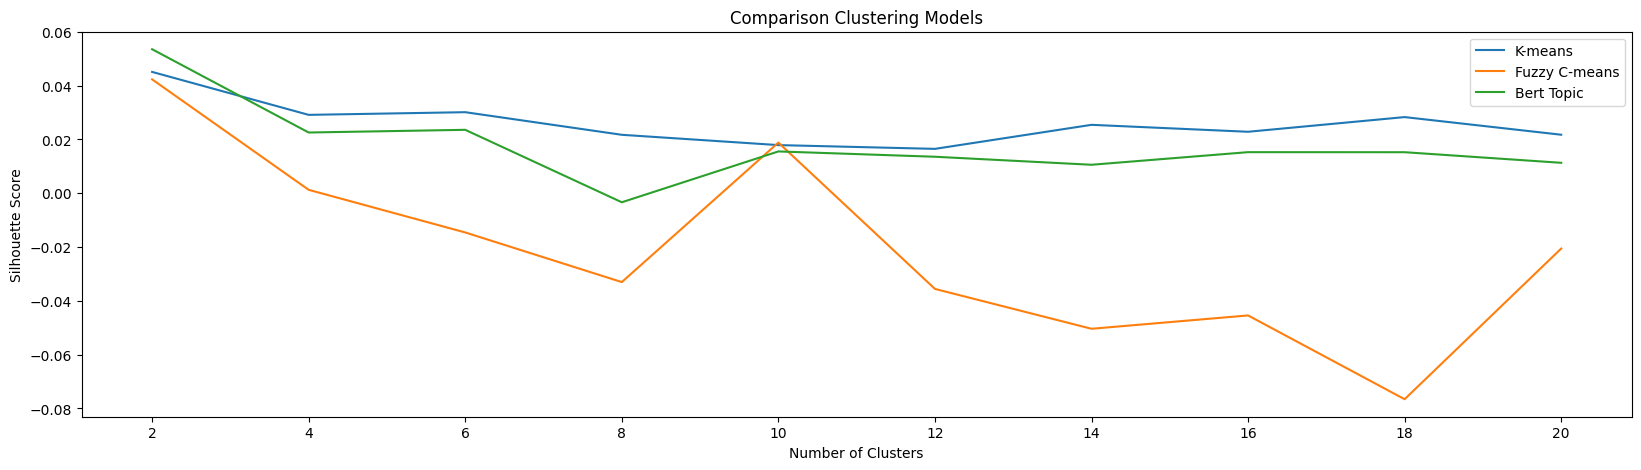

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(n_clusters, kmeans_scores, label = 'K-means')
plt.plot(n_clusters, fcm_scores, label = 'Fuzzy C-means')
plt.plot(n_clusters, bert_scores, label = 'Bert Topic')
plt.title('Comparison Clustering Models')
plt.xlabel('Number of Clusters')
plt.xticks(n_clusters)
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

# Deployment

In [ ]:
sent_transformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')

loaded_kmeans = pickle.load(open(path_kmeans_model, "rb")) # read binary
loaded_fcm = pickle.load(open(path_fcm_model, "rb")) # read binary
loaded_topic_model = BERTopic.load(path_bert_hdbscan_model)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
comment_predict = input("Input sentence to predict: ")
list_comment_predict, list_word_predict = preprocess_data(list_comment_raw = [comment_predict], testing = True)

X_predict = sent_transformer.encode(list_comment_predict).astype(np.float64)

Input sentence to predict: Gays are perverts!
Preprocessed comments: 0 / 1
Preprocessed successfully!


In [ ]:
df_kmeans_clustered = pd.read_csv(path_kmeans_clustered)
idx2name_cluster = ["other_cyberbullying", "religion", "not_cyberbullying", "ethnicity", "gender"]

kmeans_predict = loaded_kmeans.predict([X_predict[-1]]) # X_predict[-1]: only predict new data, [X_predict[-1]]: input must be an array
cluster_predict = idx2name_cluster[kmeans_predict[0]]

print("K-means prediction: Topic", cluster_predict)
print("Representative docs:", ", ".join(df_kmeans_clustered[df_kmeans_clustered['Cluster'] == cluster_predict]['Comment'].values[:10]))

K-means prediction: Topic gender
Representative docs: classy whore, isso é bullying, look dc public school bullying lgbt student gone, let talk mean victim, noticed save witty reply sexist little panache, yeap breeding violence thing well, rt ceo sony europe vehemently unequivocally condemns misogynistic harassment, best martial art stopping bullying, evidence intentionally targeting child, minnesota gay teen bullied adult peer say activist reuters reuters barb schroeder knew


In [ ]:
predicted_topic = loaded_topic_model.transform([comment_predict])

print(f"Predicted topic: {predicted_topic[0][0]}, probability: {predicted_topic[1][0]}")
loaded_topic_model.get_topic_info(topic=predicted_topic[0][0])

Predicted topic: 2, probability: 0.5107321983729708


,Topic,Count,Name,CustomName,Representation,Representative_Docs
0,2,763,2_joke_rape_gay_female,gender,"[joke, rape, gay, female, woman, call, bitch, ...","[straight gay men think rape joke funny, joke ..."
